This notebook is a tutorial for computing SEACell metacells, visualizing results and computing evaluation metrics

- Question: Is the computation for SEACell metacells for the "ATAC" modality the same as for the "RNA" modality?

- Answer: No, it's not the same. But, the authors from SEACells recommended using the ATAC modality for computing the metacells for single-cell multiome. 

# Imports

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
import SEACells

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.


In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Some plotting aesthetics
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100


# Load Data

We recommend the use of scanpy Anndata objects as the preferred mode of loading and filtering data.

A sample datset is available for download with the instructions listed below. This is a filtered, unnormalized counts of single-nuclear RNA-seq dataset of CD34+ sorted bone marrow cells to profile human hematopoiesis [Dataset ref TBD].

Uncomment the following lines to download the sample dataset in a Unix-based system. For non-UNIX systems, download the files using the URL

In [7]:
# !mkdir data/
# !wget https://dp-lab-data-public.s3.amazonaws.com/SEACells-multiome/cd34_multiome_rna.h5ad -O data/cd34_multiome_rna.h5ad 

--2022-08-17 14:35:59--  https://dp-lab-data-public.s3.amazonaws.com/SEACells-multiome/cd34_multiome_rna.h5ad
Resolving dp-lab-data-public.s3.amazonaws.com (dp-lab-data-public.s3.amazonaws.com)... 52.217.168.129
Connecting to dp-lab-data-public.s3.amazonaws.com (dp-lab-data-public.s3.amazonaws.com)|52.217.168.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152569842 (146M) [binary/octet-stream]
Saving to: 'data/cd34_multiome_rna.h5ad'

data/cd34_multiome_ 100%[===================>] 145.50M  37.8MB/s    in 4.0s    

2022-08-17 14:36:03 (36.5 MB/s) - 'data/cd34_multiome_rna.h5ad' saved [152569842/152569842]



In [5]:
# Load the pilot data
input_path = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/post_Signac_CellOracle/TDR118reseq/TDR118_processed_peaks_merged.h5ad"
ad = sc.read(input_path)

In [6]:
ad

AnnData object with n_obs × n_vars = 13614 × 485357
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'prediction.score.Lateral_Mesoderm', 'prediction.score.Neural_Crest', 'prediction.score.Somites', 'prediction.score.Epidermal', 'prediction.score.Neural_Anterior', 'prediction.score.Neural_Posterior', 'prediction.score.Endoderm', 'prediction.score.PSM', 'prediction.score.Differentiating_Neurons', 'prediction.score.Adaxial_Cells', 'prediction.score.NMPs', 'prediction.score.Notochord', 'prediction.score.Muscle', 'prediction.score.unassigned', 'prediction.score.max', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT.weight', 'peaks_merged.weight', 'nCount_Gene.Activity', 'nFeature_Gene.Activity'
    var: 'count', 'percentile'


In [84]:
# List of columns to keep (those not starting with "prediction")
columns_to_keep = [col for col in ad.obs.columns if not col.startswith("prediction")]

# Subset the adata.obs with the columns to keep
ad.obs = ad.obs[columns_to_keep]

['orig.ident',
 'nCount_RNA',
 'nFeature_RNA',
 'nCount_ATAC',
 'nFeature_ATAC',
 'nucleosome_signal',
 'nucleosome_percentile',
 'TSS.enrichment',
 'TSS.percentile',
 'nCount_SCT',
 'nFeature_SCT',
 'global_annotation',
 'nCount_peaks_bulk',
 'nFeature_peaks_bulk',
 'nCount_peaks_celltype',
 'nFeature_peaks_celltype',
 'nCount_peaks_merged',
 'nFeature_peaks_merged',
 'SCT.weight',
 'peaks_merged.weight',
 'nCount_Gene.Activity',
 'nFeature_Gene.Activity',
 'SEACell']

"ad" is not normalized nor scaled just yet. The ad.X has raw counts.

/home/yang-joon.kim/.conda/envs/seacells/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


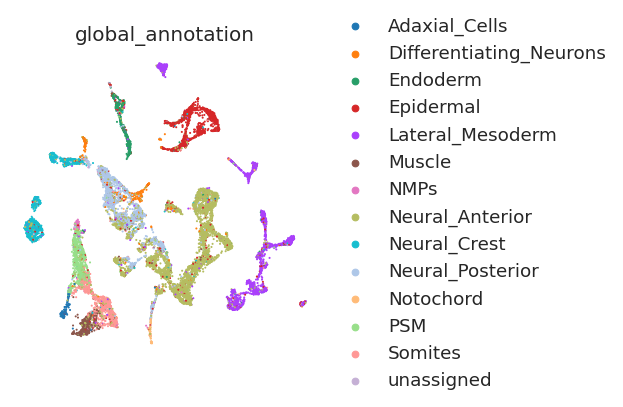

In [10]:
# Plot cell-types for reference
sc.pl.embedding(ad, basis='X_umap.atac', color='global_annotation', frameon=False)

/home/yang-joon.kim/.conda/envs/seacells/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


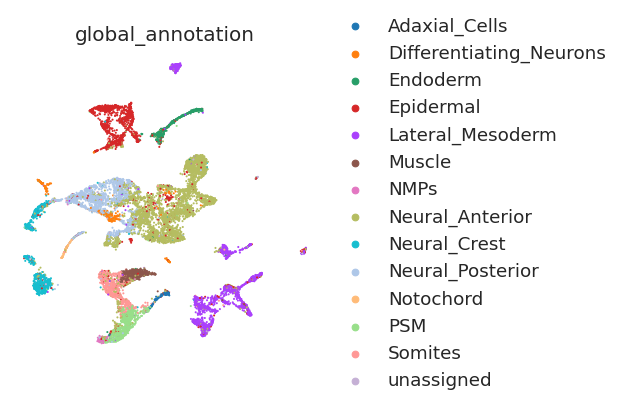

In [11]:
sc.pl.embedding(ad, basis='X_umap.joint', color='global_annotation', frameon=False)

In [12]:
ad.var.head()

,count,percentile
1-3427-4032,506.0,0.852820
1-4473-6136,2099.0,0.958727
1-11020-12944,7450.0,0.995138
1-13368-13575,437.0,0.834635
1-14640-15050,1941.0,0.955122


# Pre-processing

The following section describes basic pre-processing steps for scRNA-seq. For scATAC-seq, we provide a pipeline for pre-processing in the example notebook `preprocessing-ATAC.ipynb`

- Note: we have computed SVD during the "run_01_preprocess_multiome_object_signac.R" step. The output dim.reduction is saved under adata.obsm["X_lsi"].

In [11]:
# # Copy the counts to ".raw" attribute of the anndata since it is necessary for downstream analysis
# # This step should be performed after filtering 
# # NOTE: normally, adata.raw is for saving the log-normalized data, but for SEACells, we need the raw counts.
# raw_ad = sc.AnnData(ad.X)
# raw_ad.obs_names, raw_ad.var_names = ad.obs_names, ad.var_names
# ad.raw = raw_ad

# ad = raw_ad.copy()
# ad

In [14]:
# convert the count matrices to "raw counts"
ad.X = ad.raw.X.copy()

In [86]:
import scipy.sparse as sp

def assert_raw_counts(adata):
    # Check if the data is stored in a sparse matrix format
    if sp.issparse(adata.X):
        # Convert to dense format to work with numpy
        data = adata.X.todense()
    else:
        data = adata.X

    # Check if all values in the data are integers
    if not np.all(np.rint(data) == data):
        raise ValueError("adata.X does not contain raw counts (integer values).")

In [88]:
# Example usage
try:
    assert_raw_counts(ad)
    print("adata.X contains raw counts.")
except ValueError as e:
    print(f"Warning: {e}")

adata.X contains raw counts.


In [15]:
np.sum(ad.X.todense(),1)

matrix([[12591.],
        [ 6115.],
        [29548.],
        ...,
        [15291.],
        [ 3692.],
        [10978.]])

In [13]:
# # Normalize cells, log transform and compute highly variable genes
# sc.pp.normalize_per_cell(ad)
# sc.pp.log1p(ad)
# sc.pp.highly_variable_genes(ad, n_top_genes=1500)

In [ ]:
# perform the dimensionality reduction (LSI)


In [14]:
# # Compute principal components - 
# # Here we use 50 components. This number may also be selected by examining variance explaint
# sc.tl.pca(ad, n_comps=50, use_highly_variable=True)

# Running SEACells

As a rule of thumb, we recommended choosing one metacell for every 75 single-cells. Since this dataset contains ~7k cells, we choose 90 metacells.

<b>Note 1: </b> Running SEACells modifies the input Anndata object and adds the SEACell metacell assignments to the `obs` dataframe in the anndata object.
<b>Note 2: </b> This analysis takes approxmiately 5 minutes

In [17]:
ad.n_obs

13614

In [18]:
(ad.n_obs)/75

181.52

In [90]:
np.floor((ad.n_obs)/75)

181.0

In [23]:
ad

AnnData object with n_obs × n_vars = 13614 × 485357
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT.weight', 'peaks_merged.weight', 'nCount_Gene.Activity', 'nFeature_Gene.Activity'
    var: 'count', 'percentile'
    uns: 'global_annotation_colors', 'neighbors'
    obsm: 'X_lsi', 'X_umap.atac', 'X_umap.joint', 'X_umap.rna'
    varm: 'LSI'
    obsp: 'distances', 'connectivities'

In [24]:
## User defined parameters

## Core parameters 
n_SEACells = 180
build_kernel_on = 'X_lsi' # key in ad.obsm to use for computing metacells
                          # This would be replaced by 'X_svd' for ATAC data

## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells

In [25]:
model = SEACells.core.SEACells(ad, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  convergence_epsilon = 1e-5)

Welcome to SEACells!


In [26]:
model.construct_kernel_matrix()
M = model.kernel_matrix

Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/13614 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/13614 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/13614 [00:00<?, ?it/s]

Constructing CSR matrix...


/home/yang-joon.kim/.conda/envs/seacells/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


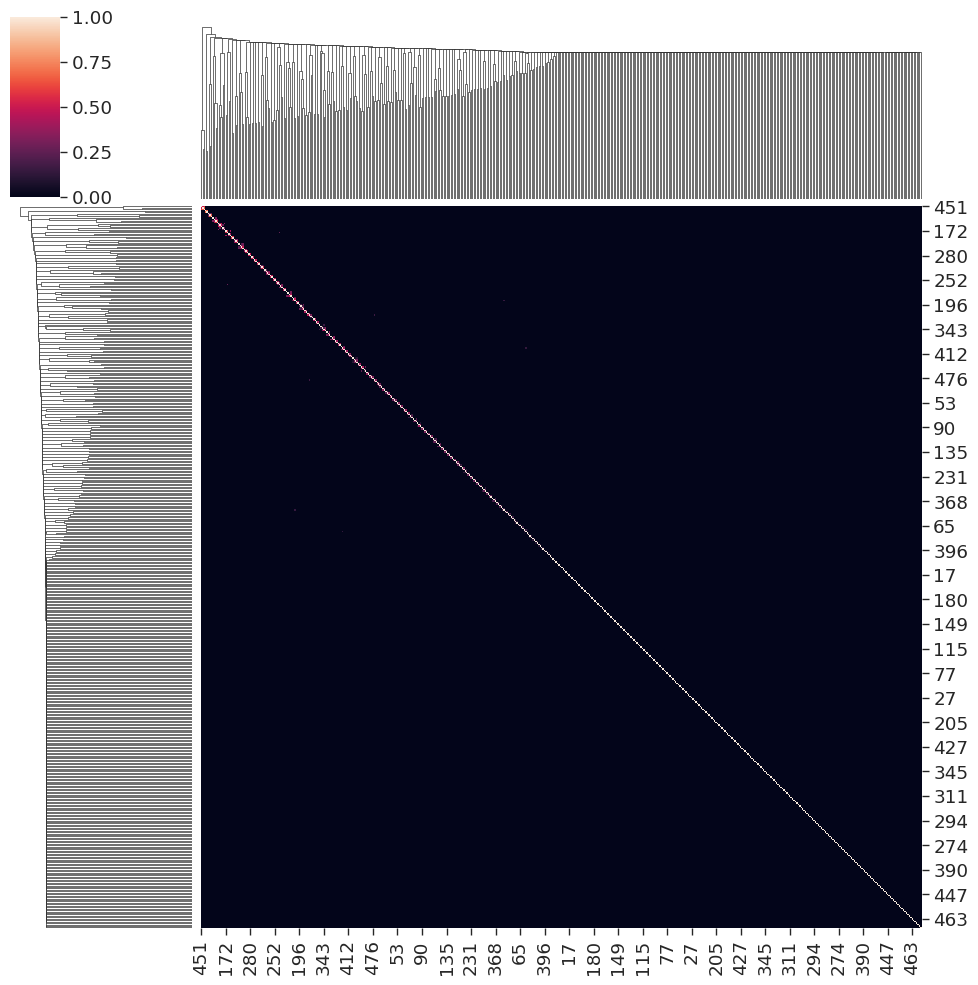

In [27]:
sns.clustermap(M.toarray()[:500,:500])

**Question: What does this heatmap mean?**

In [28]:
# Initialize archetypes
model.initialize_archetypes()

Building kernel on X_lsi
Computing diffusion components from X_lsi for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 168 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 22/22 [00:00<00:00, 87.31it/s]

Selecting 12 cells from greedy initialization.


In [29]:
help(SEACells.plot.plot_initialization)

Help on function plot_initialization in module SEACells.plot:

plot_initialization(ad, model, plot_basis='X_umap', save_as=None, show=True)
    Plot archetype initizlation
    :param ad: annData containing 'Metacells' label in .obs
    :param model: Initilized SEACells model
    :return: None



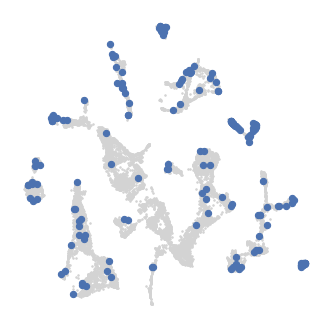

In [30]:
# Plot the initilization to ensure they are spread across phenotypic space
SEACells.plot.plot_initialization(ad, model,plot_basis="X_umap.atac")

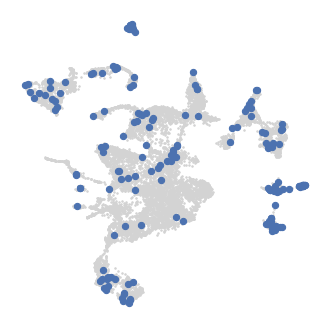

In [32]:
# Plot the initilization to ensure they are spread across phenotypic space
SEACells.plot.plot_initialization(ad, model,plot_basis="X_umap.rna")

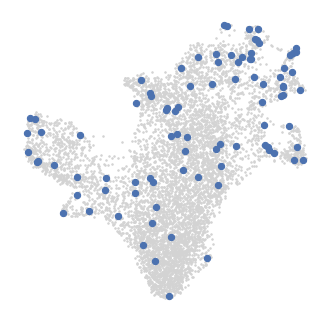

In [21]:
# example from the CD34 object
# Plot the initilization to ensure they are spread across phenotypic space
SEACells.plot.plot_initialization(ad, model)

In [34]:
model.fit(min_iter=10, max_iter=100)

Randomly initialized A matrix.
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Starting iteration 30.
Completed iteration 30.
Starting iteration 40.
Completed iteration 40.
Converged after 42 iterations.


In [23]:
# model.fit(min_iter=10, max_iter=50)

Randomly initialized A matrix.
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Starting iteration 30.
Completed iteration 30.
Converged after 38 iterations.


In [24]:
# # You can force the model to run additional iterations step-wise using the .step() function
# print(f'Ran for {len(model.RSS_iters)} iterations')
# for _ in range(5):
#     model.step()
# print(f'Ran for {len(model.RSS_iters)} iterations')

Ran for 73 iterations
Ran for 78 iterations


# Accessing results

## Model Convergence

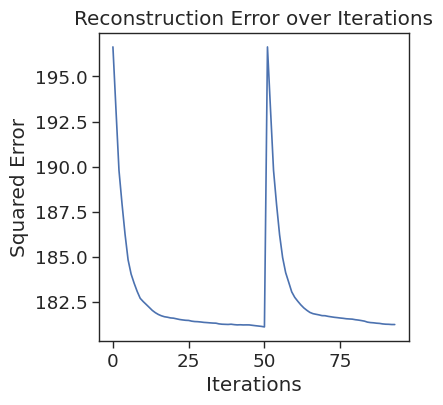

In [36]:
# Check for convergence 
model.plot_convergence()

**Q. What does this peak around iterations 38 mean?**

In [37]:
len(ad.obs.SEACell.unique())

180

In [38]:
ad.obs

,orig.ident,nCount_RNA,nFeature_RNA,nCount_ATAC,nFeature_ATAC,nucleosome_signal,nucleosome_percentile,TSS.enrichment,TSS.percentile,nCount_SCT,...,nFeature_peaks_bulk,nCount_peaks_celltype,nFeature_peaks_celltype,nCount_peaks_merged,nFeature_peaks_merged,SCT.weight,peaks_merged.weight,nCount_Gene.Activity,nFeature_Gene.Activity,SEACell
index,,,,,,,,,,,,,,,,,,,,,
AAACAGCCACCTAAGC-1,0,6522.0,2317,21425.0,9781,0.571984,0.40,4.488213,0.48,5661.0,...,10574,11790.0,9934,12591.0,10714,0.493270,0.506730,12380.0,7106,SEACell-158
AAACAGCCAGGGAGGA-1,0,6100.0,2319,10334.0,5028,0.448143,0.13,4.795205,0.75,5553.0,...,5567,5667.0,5123,6115.0,5563,0.498962,0.501038,6192.0,4256,SEACell-152
AAACAGCCATAGACCC-1,0,12581.0,3467,51485.0,19874,0.514213,0.24,5.238692,0.92,5781.0,...,21166,28070.0,19930,29548.0,21333,0.572315,0.427685,26083.0,10345,SEACell-83
AAACATGCAAACTCAT-1,0,5642.0,2145,19812.0,9183,0.673319,0.85,4.409525,0.41,5363.0,...,9811,10763.0,9116,11621.0,9939,0.481765,0.518235,11748.0,6534,SEACell-49
AAACATGCAAGGACCA-1,0,2691.0,838,5182.0,2565,0.394904,0.06,4.939061,0.83,4727.0,...,2766,2781.0,2559,2983.0,2761,0.408465,0.591535,3061.0,2376,SEACell-112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTCGACTCC-1,0,4328.0,1869,2076.0,1077,0.548780,0.33,4.571429,0.56,4708.0,...,1161,1136.0,1096,1202.0,1161,0.426838,0.573162,1238.0,1096,SEACell-177
TTTGTTGGTGATTTGG-1,0,5069.0,1542,23253.0,10675,0.685358,0.88,4.455793,0.45,5082.0,...,11563,12827.0,10794,13769.0,11703,0.525927,0.474073,13447.0,7665,SEACell-122
TTTGTTGGTTCACCCA-1,0,4562.0,1692,26154.0,11598,0.655172,0.78,4.649127,0.63,4851.0,...,12442,14410.0,11679,15291.0,12527,0.264328,0.735672,14375.0,7766,SEACell-30


In [39]:
ad.obs.SEACell.value_counts()

SEACell-70     221
SEACell-95     197
SEACell-97     180
SEACell-166    179
SEACell-44     175
              ... 
SEACell-160     25
SEACell-145     23
SEACell-92      23
SEACell-94      21
SEACell-63      18
Name: SEACell, Length: 180, dtype: int64

Text(0, 0.5, 'counts')

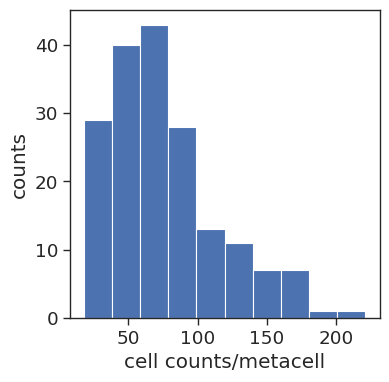

In [41]:
plt.hist(ad.obs.SEACell.value_counts())
plt.xlabel("cell counts/metacell")
plt.ylabel("counts")

## SEACell Hard Assignments

These can be accessed as follows:
- in the modified anndata object in `.obs['SEACell']` 
- from the model using `.get_hard_assignments()` 


In [42]:
ad.obs[['SEACell']].head()

,SEACell
index,
AAACAGCCACCTAAGC-1,SEACell-158
AAACAGCCAGGGAGGA-1,SEACell-152
AAACAGCCATAGACCC-1,SEACell-83
AAACATGCAAACTCAT-1,SEACell-49
AAACATGCAAGGACCA-1,SEACell-112


In [43]:
model.get_hard_assignments().head()

,SEACell
index,
AAACAGCCACCTAAGC-1,SEACell-158
AAACAGCCAGGGAGGA-1,SEACell-152
AAACAGCCATAGACCC-1,SEACell-83
AAACATGCAAACTCAT-1,SEACell-49
AAACATGCAAGGACCA-1,SEACell-112


## SEACell Soft Assignments

Archetypal analysis returns soft assignments of cells to SEACells. The full assignment matrix can be accessed as the parameter ```model.A_```. However, the majority of single-cells are assigned to no more than 4 archetypes with non-trivial weight, so we return the top 5 metacell assignments as well as the corresponding assignment weights in the function ```model.get_soft_assignments()```

In [44]:
model.get_soft_assignments()

(                                     0                   1  \
 index                                                        
 AAACAGCCACCTAAGC-1  GCTTTGTGTGAGGTGA-1  GATTGTTCAATGAAGC-1   
 AAACAGCCAGGGAGGA-1  TGCGATTAGCTATATG-1  AACCCGCAGCAGCTCA-1   
 AAACAGCCATAGACCC-1  ATTGCACAGTAAGAAC-1  GTGTCCAAGTCATTGA-1   
 AAACATGCAAACTCAT-1  CTGAATATCAATCTAG-1  TCTCAAGCACAGGGAC-1   
 AAACATGCAAGGACCA-1  CGCGATTCAGCAAGTG-1  GTCATGCCAGTAATAG-1   
 ...                                ...                 ...   
 TTTGTTGGTCGACTCC-1  TCGCATTGTTGCGTAA-1  TAGTTGTCATTGTGCA-1   
 TTTGTTGGTGATTTGG-1  GCATCCTTCCAGCACA-1  ACTAAAGCACAACAGG-1   
 TTTGTTGGTTCACCCA-1  AAACGCGCATGCATAT-1  CAATAGCTCGAGGAGT-1   
 TTTGTTGGTTCGGGAT-1  TATAGCCAGAACCTAC-1  GCGCGATTCCCGCATT-1   
 TTTGTTGGTTTGTGGA-1  CAATGTCAGCGGATTT-1  GACCTAGTCTTGACCC-1   
 
                                      2                   3                   4  
 index                                                                           
 AAACAGCCACCTAA

/home/yangjoon.kim/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


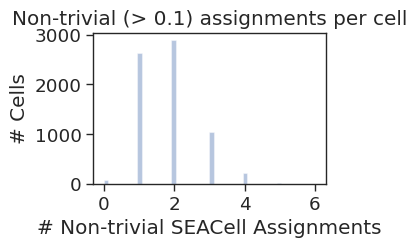

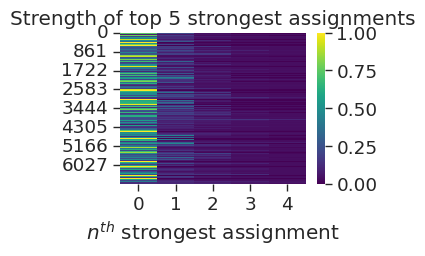

In [43]:
# plt.figure(figsize=(3,2))
# sns.distplot((model.A_.T > 0.1).sum(axis=1), kde=False)
# plt.title(f'Non-trivial (> 0.1) assignments per cell')
# plt.xlabel('# Non-trivial SEACell Assignments')
# plt.ylabel('# Cells')
# plt.show()

# plt.figure(figsize=(3,2))
# b = np.partition(model.A_.T, -5)    
# sns.heatmap(np.sort(b[:,-5:])[:, ::-1], cmap='viridis', vmin=0)
# plt.title('Strength of top 5 strongest assignments')
# plt.xlabel('$n^{th}$ strongest assignment')
# plt.show()


/tmp/ipykernel_2664464/2761727437.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((model.A_.T > 0.1).sum(axis=1), kde=False)


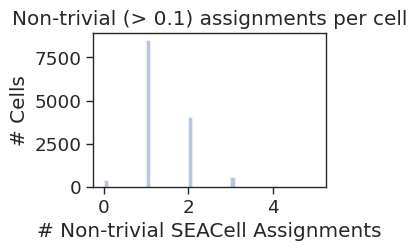

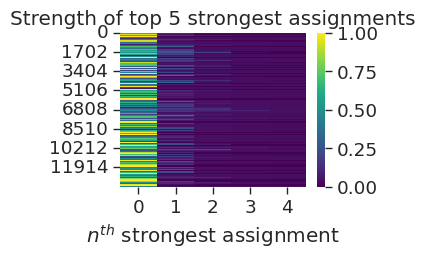

In [45]:
plt.figure(figsize=(3,2))
sns.distplot((model.A_.T > 0.1).sum(axis=1), kde=False)
plt.title(f'Non-trivial (> 0.1) assignments per cell')
plt.xlabel('# Non-trivial SEACell Assignments')
plt.ylabel('# Cells')
plt.show()

plt.figure(figsize=(3,2))
b = np.partition(model.A_.T, -5)    
sns.heatmap(np.sort(b[:,-5:])[:, ::-1], cmap='viridis', vmin=0)
plt.title('Strength of top 5 strongest assignments')
plt.xlabel('$n^{th}$ strongest assignment')
plt.show()

In [46]:
labels,weights = model.get_soft_assignments()

In [47]:
labels.head()

,0,1,2,3,4
index,,,,,
AAACAGCCACCTAAGC-1,GCTTTGTGTGAGGTGA-1,GATTGTTCAATGAAGC-1,CGTTAAATCGTAACGT-1,CATGCGGGTTGGGTTA-1,GTCATGCCAGTAATAG-1
AAACAGCCAGGGAGGA-1,TGCGATTAGCTATATG-1,AACCCGCAGCAGCTCA-1,AGCATTTCAGCTTAGC-1,GGCAATCGTTTGGGTA-1,ATAGCATGTGCCTCAC-1
AAACAGCCATAGACCC-1,ATTGCACAGTAAGAAC-1,GTGTCCAAGTCATTGA-1,CGAGCGAAGCTATTGA-1,GTTAACGGTATTCGTC-1,ACTGAATGTTGCAGTA-1
AAACATGCAAACTCAT-1,CTGAATATCAATCTAG-1,TCTCAAGCACAGGGAC-1,GAGTGTTTCCTTGCAC-1,GCTCATTGTTGGTTCT-1,CGTTAAATCGTAACGT-1
AAACATGCAAGGACCA-1,CGCGATTCAGCAAGTG-1,GTCATGCCAGTAATAG-1,CTATTGAAGATAAAGC-1,ATGGACAAGGGCCACT-1,CGTTAAATCGTAACGT-1


# Summarizing data

- `core.summarize_by_SEACell()`

Datasets can be summarized by SEACell by aggregating cells within each SEACell, summing over all raw data for all cells belonging to a SEACell. The output of this function is an anndata object of shape n_metacells x original_data_dimension. Data is unnormalized and raw aggregated counts are stored in `X`. Attributes associated with variables (.var) are copied over, but relevant per SEACell attributes must be manually copied, since certain attributes may need to be summed, or averaged etc, depending on the attribute.

By default, `ad.raw` is used for summarization. Other layers present in the anndata can be specified using the parameter `summarize_layer` parameter

In [48]:
SEACell_ad = SEACells.core.summarize_by_SEACell(ad, SEACells_label='SEACell', summarize_layer='raw')
SEACell_ad

100%|██████████| 180/180 [00:01<00:00, 138.08it/s]


AnnData object with n_obs × n_vars = 180 × 485357
    layers: 'raw'

Alternatively, we can take into account soft assignments of cells to SEACells by weighting cells by the strength of the assignment. A minimum assignment weight is used to zero out trivial assignments

In [49]:
SEACell_soft_ad = SEACells.core.summarize_by_soft_SEACell(ad, model.A_, celltype_label='global_annotation',summarize_layer='raw', minimum_weight=0.05)
SEACell_soft_ad

/home/yang-joon.kim/.conda/envs/seacells/lib/python3.8/site-packages/SEACells-0.3.3-py3.8.egg/SEACells/core.py:102: RuntimeWarning: invalid value encountered in divide
  A = A / A.sum(1, keepdims=True)
100%|██████████| 180/180 [55:24<00:00, 18.47s/it]


AnnData object with n_obs × n_vars = 180 × 485357
    obs: 'Pseudo-sizes', 'celltype', 'celltype_purity'

In [94]:
SEACell_soft_ad

AnnData object with n_obs × n_vars = 180 × 485357
    obs: 'Pseudo-sizes', 'celltype', 'celltype_purity'

In [50]:
SEACell_soft_ad.obs.head()

,Pseudo-sizes,celltype,celltype_purity
0,NaN,Neural_Anterior,0.856009
1,NaN,Neural_Anterior,0.912763
2,NaN,Epidermal,0.745810
3,NaN,Lateral_Mesoderm,0.995212
4,NaN,Neural_Posterior,0.628751


In [51]:
SEACell_soft_ad.obs["celltype"].value_counts()

Lateral_Mesoderm           43
Neural_Anterior            40
Neural_Posterior           20
Neural_Crest               18
Epidermal                  16
Endoderm                   12
PSM                        11
Somites                     6
Muscle                      5
Differentiating_Neurons     3
NMPs                        2
Adaxial_Cells               2
Notochord                   1
unassigned                  1
Name: celltype, dtype: int64

## Normalization

Normalization of metacell data can be performed using the `sc.pp.normalize_total` and `sc.pp.log1p` functions

# Evaluating Results

We provide several methods for evaluating SEACell assignments:

## Visualizing Results

Metacells also implements methods for visualizing the results of the Metacells algorithm 
    <ul> 
        <li>```.plot_2D()``` provides an interface for viewing metacell assignments on any 2-dimensional embedding in ad.obsm. Plots can also be coloured by metacell assignment.
        <li>```.plot_SEACell_sizes()``` can be used to view the distribution of number of cells assigned to each metacell
    </ul>
    
            

/home/yang-joon.kim/.conda/envs/seacells/lib/python3.8/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/home/yang-joon.kim/.conda/envs/seacells/lib/python3.8/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


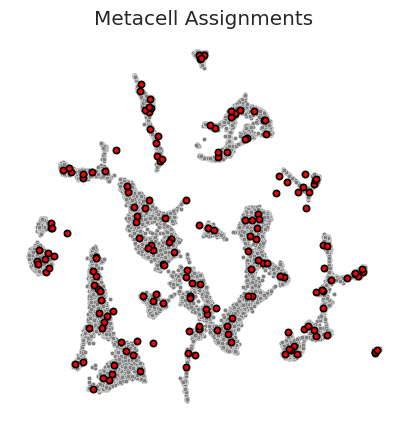

In [52]:
SEACells.plot.plot_2D(ad, key='X_umap.atac', colour_metacells=False)

/home/yang-joon.kim/.conda/envs/seacells/lib/python3.8/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/home/yang-joon.kim/.conda/envs/seacells/lib/python3.8/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


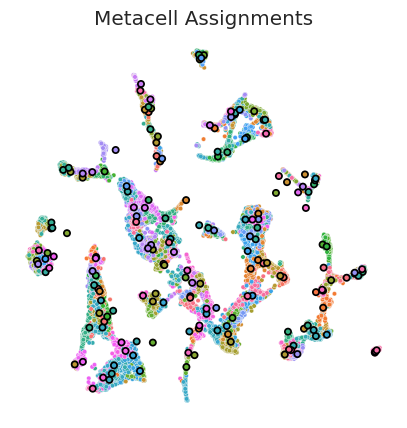

In [61]:
SEACells.plot.plot_2D(ad, key='X_umap.atac', colour_metacells=True)

/home/yang-joon.kim/.conda/envs/seacells/lib/python3.8/site-packages/SEACells-0.3.3-py3.8.egg/SEACells/plot.py:121: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(label_df.groupby('SEACell').count().iloc[:, 0], bins=bins)


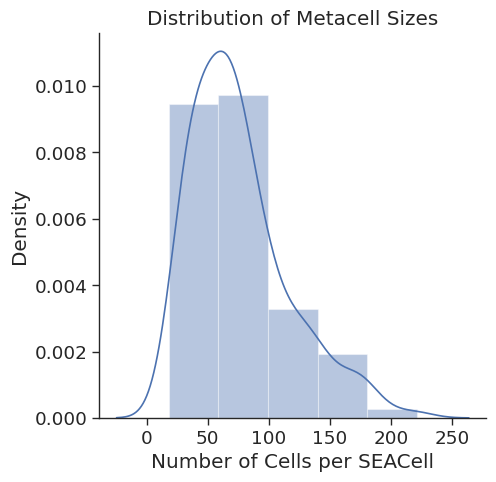

,size
SEACell,
SEACell-0,84
SEACell-1,55
SEACell-10,42
SEACell-100,124
SEACell-101,121
...,...
SEACell-95,197
SEACell-96,91
SEACell-97,180


In [62]:
SEACells.plot.plot_SEACell_sizes(ad, bins=5)

## Quantifying Results

SEACells also implements methods for visualizing the results of the SEACells algorithm 
    <ul> 
        <li>```.compute_celltype_purity(ad, col_name)``` computes the purity of different celltype labels within a SEACell metacell. Typically, col_name='celltype' or similar. Returns a pd.DataFrame of length n_SEACells.
        <li>```.compactness(ad, low_dim_embedding)``` computes the per-SEAcell variance in diffusion components. ```low_dim_embedding``` is a string specifying the low dimensional embedding with which diffusion components are calculated, typically 'X_pca' for RNA or 'X_svd' for ATAC. Lower values of compactness suggest more compact/lower variance metacells.
        <li>```separation(ad, low_dim_embedding,nth_nbr=1,cluster=None)``` computes the diffusion distance between a SEACell and its ```nth_nbr```. As before, ```low_dim_embedding``` is a string specifying the low dimensional embedding with which diffusion components are calculated, typically 'X_pca' for RNA or 'X_svd' for ATAC. If ```cluster``` is provided as a string, e.g. 'celltype', nearest neighbors are restricted to have the same celltype value.  Higher values of separation suggest better distinction between metacells.
    </ul>
    


In [63]:
ad

AnnData object with n_obs × n_vars = 13614 × 485357
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT.weight', 'peaks_merged.weight', 'nCount_Gene.Activity', 'nFeature_Gene.Activity', 'SEACell'
    var: 'count', 'percentile'
    uns: 'global_annotation_colors', 'neighbors'
    obsm: 'X_lsi', 'X_umap.atac', 'X_umap.joint', 'X_umap.rna'
    varm: 'LSI'
    obsp: 'distances', 'connectivities'

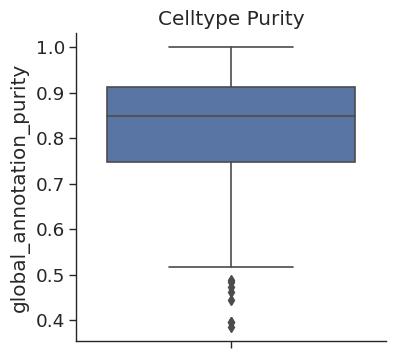

,global_annotation,global_annotation_purity
SEACell,,
SEACell-0,Neural_Anterior,0.880952
SEACell-1,Neural_Anterior,0.927273
SEACell-10,Lateral_Mesoderm,0.833333
SEACell-100,Neural_Anterior,0.911290
SEACell-101,PSM,0.396694


In [64]:
SEACell_purity = SEACells.evaluate.compute_celltype_purity(ad, 'global_annotation')

plt.figure(figsize=(4,4))
sns.boxplot(data=SEACell_purity, y='global_annotation_purity')
plt.title('Celltype Purity')
sns.despine()
plt.show()
plt.close()

SEACell_purity.head()

In [65]:
SEACell_purity = SEACells.evaluate.compute_celltype_purity(ad, 'global_annotation')
SEACell_purity

,global_annotation,global_annotation_purity
SEACell,,
SEACell-0,Neural_Anterior,0.880952
SEACell-1,Neural_Anterior,0.927273
SEACell-10,Lateral_Mesoderm,0.833333
SEACell-100,Neural_Anterior,0.911290
SEACell-101,PSM,0.396694
...,...,...
SEACell-95,Neural_Anterior,0.918782
SEACell-96,Neural_Posterior,0.703297
SEACell-97,Neural_Posterior,0.833333


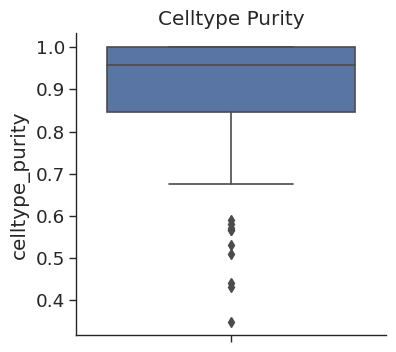

,celltype,celltype_purity
SEACell,,
SEACell-0,DCPre,0.860465
SEACell-1,HMP,1.000000
SEACell-10,HMP,0.984252
SEACell-11,pDC,0.894737
SEACell-12,cDC,1.000000


In [53]:
# SEACell_purity = SEACells.evaluate.compute_celltype_purity(ad, 'celltype')

# plt.figure(figsize=(4,4))
# sns.boxplot(data=SEACell_purity, y='celltype_purity')
# plt.title('Celltype Purity')
# sns.despine()
# plt.show()
# plt.close()

# SEACell_purity.head()

In [66]:
ad

AnnData object with n_obs × n_vars = 13614 × 485357
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT.weight', 'peaks_merged.weight', 'nCount_Gene.Activity', 'nFeature_Gene.Activity', 'SEACell'
    var: 'count', 'percentile'
    uns: 'global_annotation_colors', 'neighbors'
    obsm: 'X_lsi', 'X_umap.atac', 'X_umap.joint', 'X_umap.rna'
    varm: 'LSI'
    obsp: 'distances', 'connectivities'

Determing nearest neighbor graph...


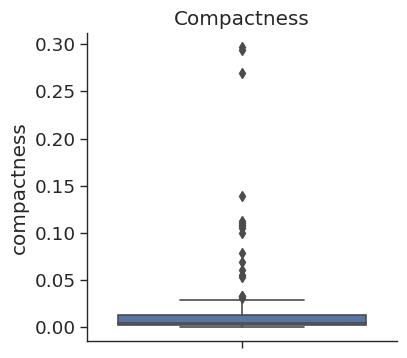

,compactness
SEACell,
SEACell-0,0.001367
SEACell-1,0.005893
SEACell-10,0.018311
SEACell-100,0.001119
SEACell-101,0.002753


In [68]:
compactness = SEACells.evaluate.compactness(ad, 'X_lsi')

plt.figure(figsize=(4,4))
sns.boxplot(data=compactness, y='compactness')
plt.title('Compactness')
sns.despine()
plt.show()
plt.close()

compactness.head()

Determing nearest neighbor graph...


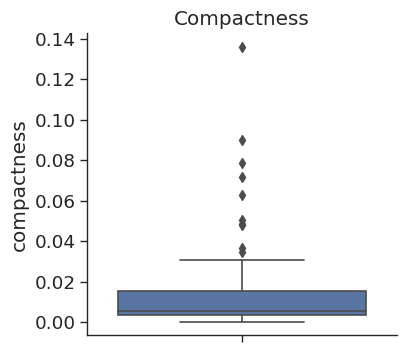

,compactness
SEACell,
SEACell-0,0.004388
SEACell-1,0.003220
SEACell-10,0.003101
SEACell-11,0.019933
SEACell-12,0.003633


In [54]:
# compactness = SEACells.evaluate.compactness(ad, 'X_pca')

# plt.figure(figsize=(4,4))
# sns.boxplot(data=compactness, y='compactness')
# plt.title('Compactness')
# sns.despine()
# plt.show()
# plt.close()

# compactness.head()

Determing nearest neighbor graph...


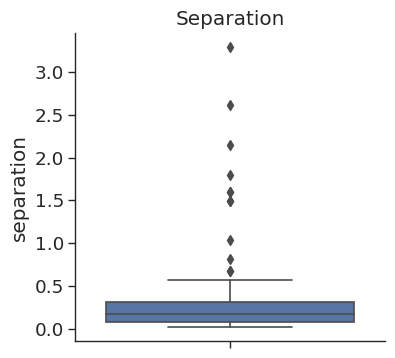

,separation
SEACell,
SEACell-0,0.070780
SEACell-1,0.230281
SEACell-10,0.398365
SEACell-100,0.100103
SEACell-101,0.219049


In [69]:
separation = SEACells.evaluate.separation(ad, 'X_lsi',nth_nbr=1)

plt.figure(figsize=(4,4))
sns.boxplot(data=separation, y='separation')
plt.title('Separation')
sns.despine()
plt.show()
plt.close()

separation.head()

Determing nearest neighbor graph...


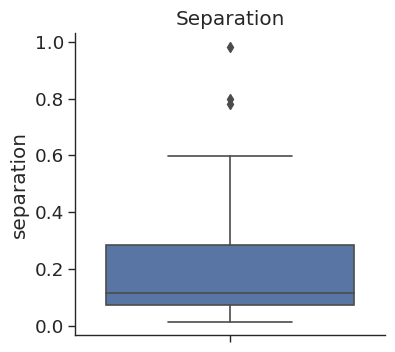

,separation
SEACell,
SEACell-0,0.113939
SEACell-1,0.107417
SEACell-10,0.107417
SEACell-11,0.377124
SEACell-12,0.100838


In [55]:
# separation = SEACells.evaluate.separation(ad, 'X_pca',nth_nbr=1)

# plt.figure(figsize=(4,4))
# sns.boxplot(data=separation, y='separation')
# plt.title('Separation')
# sns.despine()
# plt.show()
# plt.close()

# separation.head()

In [70]:
import umap as py
py.__version__

'0.5.4'

In [72]:
ad.obs.SEACell

index
AAACAGCCACCTAAGC-1    SEACell-158
AAACAGCCAGGGAGGA-1    SEACell-152
AAACAGCCATAGACCC-1     SEACell-83
AAACATGCAAACTCAT-1     SEACell-49
AAACATGCAAGGACCA-1    SEACell-112
                         ...     
TTTGTTGGTCGACTCC-1    SEACell-177
TTTGTTGGTGATTTGG-1    SEACell-122
TTTGTTGGTTCACCCA-1     SEACell-30
TTTGTTGGTTCGGGAT-1     SEACell-73
TTTGTTGGTTTGTGGA-1     SEACell-28
Name: SEACell, Length: 13614, dtype: object

In [73]:
# save the data object with the SEACells assignment
ad.write_h5ad("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/05_SEACells_processed/TDR118_ATAC_SEACells.h5ad")